In [8]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [10]:
data_dir = "trafic_32"

transform = transforms.Compose([
    transforms.ToTensor(),
])


In [11]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
print(len(full_dataset.classes))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

43


tensor([16, 30, 10, 27,  1,  5,  4,  2])
Input shape: torch.Size([8, 3, 32, 32])


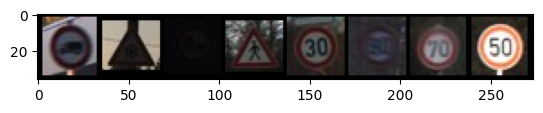

In [12]:
x, y = next(iter(train_loader))
x,y = x[:8], y[:8]
print(y)
print(f"Input shape: {x.shape}")
plt.imshow(torchvision.utils.make_grid(x).permute(1, 2, 0))

### Diffusion model

In [22]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x*(1 - amount) + noise*amount

In [36]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=1, class_emb_dim=1):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.class_emb_dim = class_emb_dim
        self.total_emb_dim = time_emb_dim + class_emb_dim

        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])

        self.up_layers = nn.ModuleList([
            nn.Conv2d(64 + self.total_emb_dim, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t, y):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Expand time and label embeddings
        t = t.view(t.size(0), self.time_emb_dim, 1, 1).repeat(1, 1, x.size(2), x.size(3))
        y = y.view(y.size(0), self.class_emb_dim, 1, 1).repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t, y], dim=1)

        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))

        return x

In [37]:
net = BasicUNet().to(device)
net

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(66, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [38]:
n_epochs = 10

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


In [39]:
losses = []

for epoch in range(n_epochs):

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount,y)

        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Finished epoch {epoch}, Avg epoch loss: {avg_loss:.5f}")

Finished epoch 0, Avg epoch loss: 0.02144
Finished epoch 1, Avg epoch loss: 0.01596
Finished epoch 2, Avg epoch loss: 0.01454
Finished epoch 3, Avg epoch loss: 0.01374
Finished epoch 4, Avg epoch loss: 0.01357
Finished epoch 5, Avg epoch loss: 0.01325
Finished epoch 6, Avg epoch loss: 0.01259
Finished epoch 7, Avg epoch loss: 0.01284
Finished epoch 8, Avg epoch loss: 0.01271
Finished epoch 9, Avg epoch loss: 0.01243


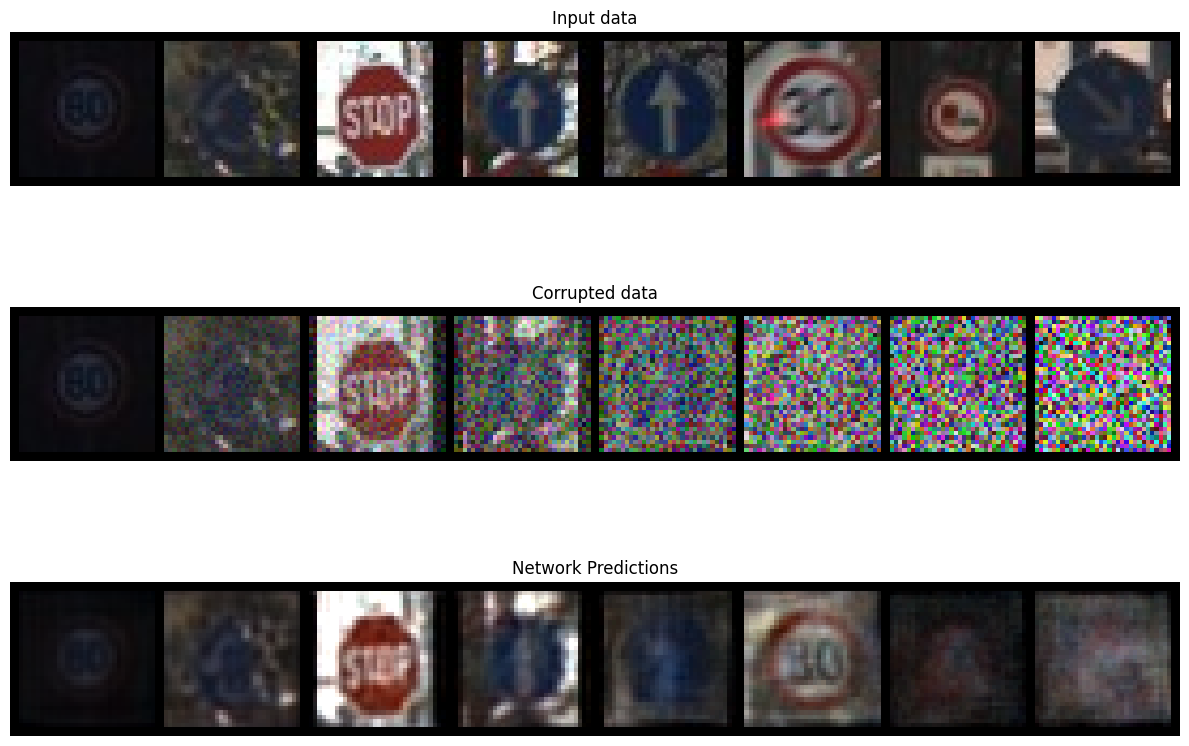

In [40]:
x, y = next(iter(val_loader))
x, y = x[:8], y[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device), y.to(device)).detach().cpu()

# --- Step 8: Show results ---
def show_batch(title, imgs, ax):
    grid = torchvision.utils.make_grid(imgs, nrow=imgs.size(0))
    grid = grid.permute(1, 2, 0).clip(0, 1).cpu().numpy()
    ax.imshow(grid)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

show_batch("Input data",        x,        axs[0])
show_batch("Corrupted data",    noised_x, axs[1])
show_batch("Network Predictions", preds,  axs[2])

plt.tight_layout()
plt.show()

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:

n_steps = 40
x = torch.rand(8,3, 32, 32).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
    print(f"Timestep: {t[0].item():.2}")
    with torch.no_grad():
        pred = net(x, t) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    #---------- Uzupełnij proces generowania
    mix_factor = 1/(n_steps -i)
    x = x*(1-mix_factor) + pred*mix_factor # Mix the prediction with the current x
    #---------------------------------------
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [19]:
import torch.optim as optim
# Models
latent_dim = 64
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [20]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.105, discriminator real acc: 0.763


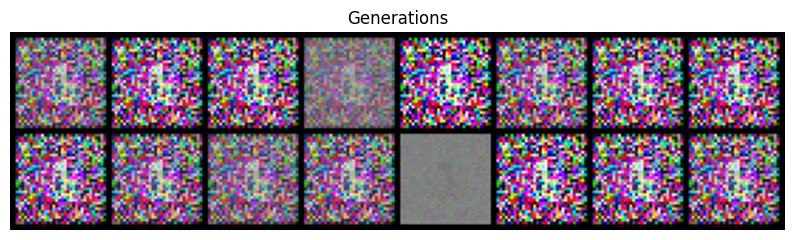

Epoch: 1, discrimiantor fake error: 0.0567, discriminator real acc: 0.924
Epoch: 2, discrimiantor fake error: 0.0615, discriminator real acc: 0.928
Epoch: 3, discrimiantor fake error: 0.0882, discriminator real acc: 0.909
Epoch: 4, discrimiantor fake error: 0.0858, discriminator real acc: 0.915
Epoch: 5, discrimiantor fake error: 0.123, discriminator real acc: 0.88
Epoch: 6, discrimiantor fake error: 0.121, discriminator real acc: 0.882
Epoch: 7, discrimiantor fake error: 0.146, discriminator real acc: 0.86
Epoch: 8, discrimiantor fake error: 0.174, discriminator real acc: 0.835
Epoch: 9, discrimiantor fake error: 0.179, discriminator real acc: 0.825
Epoch: 10, discrimiantor fake error: 0.194, discriminator real acc: 0.814


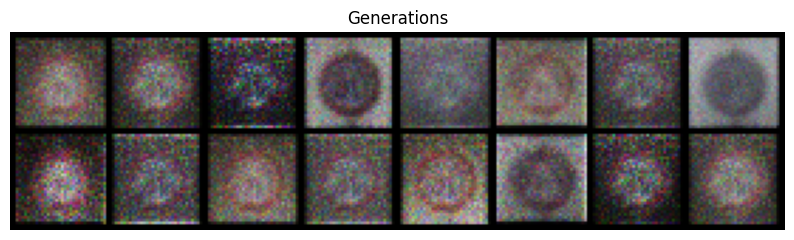

Epoch: 11, discrimiantor fake error: 0.185, discriminator real acc: 0.82
Epoch: 12, discrimiantor fake error: 0.187, discriminator real acc: 0.816
Epoch: 13, discrimiantor fake error: 0.189, discriminator real acc: 0.816
Epoch: 14, discrimiantor fake error: 0.201, discriminator real acc: 0.803
Epoch: 15, discrimiantor fake error: 0.207, discriminator real acc: 0.8
Epoch: 16, discrimiantor fake error: 0.193, discriminator real acc: 0.814
Epoch: 17, discrimiantor fake error: 0.184, discriminator real acc: 0.823
Epoch: 18, discrimiantor fake error: 0.183, discriminator real acc: 0.821
Epoch: 19, discrimiantor fake error: 0.204, discriminator real acc: 0.801
Epoch: 20, discrimiantor fake error: 0.191, discriminator real acc: 0.802


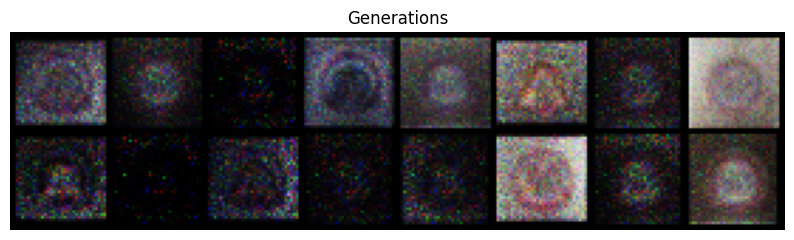

Epoch: 21, discrimiantor fake error: 0.184, discriminator real acc: 0.815
Epoch: 22, discrimiantor fake error: 0.18, discriminator real acc: 0.817
Epoch: 23, discrimiantor fake error: 0.177, discriminator real acc: 0.82
Epoch: 24, discrimiantor fake error: 0.185, discriminator real acc: 0.813
Epoch: 25, discrimiantor fake error: 0.181, discriminator real acc: 0.82
Epoch: 26, discrimiantor fake error: 0.182, discriminator real acc: 0.817
Epoch: 27, discrimiantor fake error: 0.185, discriminator real acc: 0.818
Epoch: 28, discrimiantor fake error: 0.189, discriminator real acc: 0.811
Epoch: 29, discrimiantor fake error: 0.2, discriminator real acc: 0.805
Epoch: 30, discrimiantor fake error: 0.201, discriminator real acc: 0.801


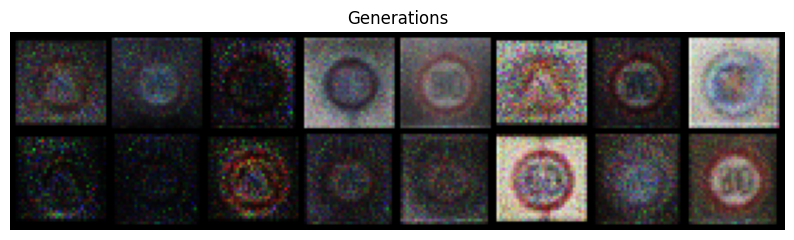

Epoch: 31, discrimiantor fake error: 0.203, discriminator real acc: 0.797
Epoch: 32, discrimiantor fake error: 0.2, discriminator real acc: 0.806
Epoch: 33, discrimiantor fake error: 0.214, discriminator real acc: 0.793
Epoch: 34, discrimiantor fake error: 0.214, discriminator real acc: 0.789
Epoch: 35, discrimiantor fake error: 0.212, discriminator real acc: 0.792
Epoch: 36, discrimiantor fake error: 0.208, discriminator real acc: 0.796
Epoch: 37, discrimiantor fake error: 0.206, discriminator real acc: 0.797
Epoch: 38, discrimiantor fake error: 0.192, discriminator real acc: 0.81
Epoch: 39, discrimiantor fake error: 0.205, discriminator real acc: 0.796
Epoch: 40, discrimiantor fake error: 0.212, discriminator real acc: 0.788


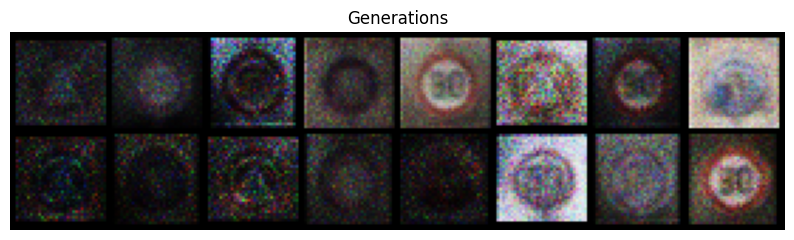

Epoch: 41, discrimiantor fake error: 0.206, discriminator real acc: 0.792
Epoch: 42, discrimiantor fake error: 0.213, discriminator real acc: 0.783
Epoch: 43, discrimiantor fake error: 0.211, discriminator real acc: 0.786
Epoch: 44, discrimiantor fake error: 0.211, discriminator real acc: 0.789
Epoch: 45, discrimiantor fake error: 0.217, discriminator real acc: 0.782
Epoch: 46, discrimiantor fake error: 0.216, discriminator real acc: 0.783
Epoch: 47, discrimiantor fake error: 0.219, discriminator real acc: 0.782
Epoch: 48, discrimiantor fake error: 0.224, discriminator real acc: 0.776
Epoch: 49, discrimiantor fake error: 0.217, discriminator real acc: 0.783
Epoch: 50, discrimiantor fake error: 0.235, discriminator real acc: 0.766


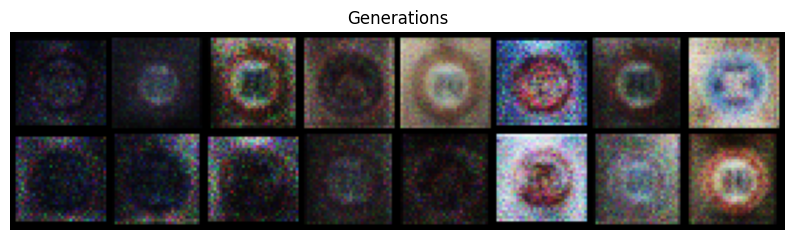

Epoch: 51, discrimiantor fake error: 0.241, discriminator real acc: 0.756
Epoch: 52, discrimiantor fake error: 0.233, discriminator real acc: 0.765
Epoch: 53, discrimiantor fake error: 0.241, discriminator real acc: 0.759
Epoch: 54, discrimiantor fake error: 0.244, discriminator real acc: 0.758
Epoch: 55, discrimiantor fake error: 0.243, discriminator real acc: 0.755
Epoch: 56, discrimiantor fake error: 0.256, discriminator real acc: 0.742
Epoch: 57, discrimiantor fake error: 0.26, discriminator real acc: 0.74
Epoch: 58, discrimiantor fake error: 0.262, discriminator real acc: 0.737
Epoch: 59, discrimiantor fake error: 0.266, discriminator real acc: 0.735
Epoch: 60, discrimiantor fake error: 0.261, discriminator real acc: 0.738


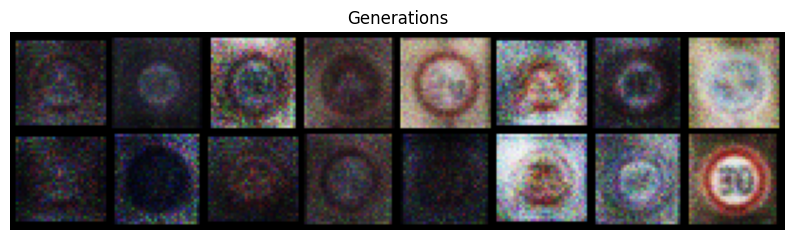

Epoch: 61, discrimiantor fake error: 0.262, discriminator real acc: 0.738
Epoch: 62, discrimiantor fake error: 0.274, discriminator real acc: 0.727
Epoch: 63, discrimiantor fake error: 0.269, discriminator real acc: 0.726
Epoch: 64, discrimiantor fake error: 0.269, discriminator real acc: 0.732
Epoch: 65, discrimiantor fake error: 0.271, discriminator real acc: 0.73
Epoch: 66, discrimiantor fake error: 0.268, discriminator real acc: 0.731
Epoch: 67, discrimiantor fake error: 0.265, discriminator real acc: 0.734
Epoch: 68, discrimiantor fake error: 0.278, discriminator real acc: 0.723
Epoch: 69, discrimiantor fake error: 0.273, discriminator real acc: 0.726
Epoch: 70, discrimiantor fake error: 0.275, discriminator real acc: 0.731


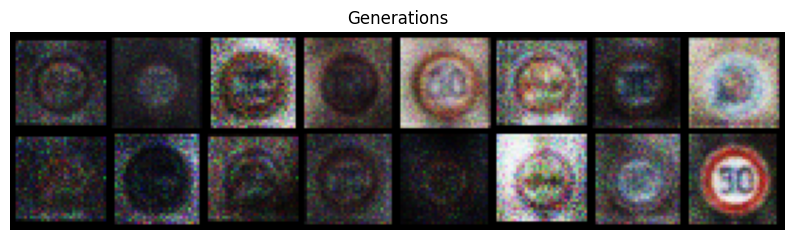

Epoch: 71, discrimiantor fake error: 0.262, discriminator real acc: 0.738
Epoch: 72, discrimiantor fake error: 0.282, discriminator real acc: 0.721
Epoch: 73, discrimiantor fake error: 0.282, discriminator real acc: 0.72
Epoch: 74, discrimiantor fake error: 0.279, discriminator real acc: 0.722
Epoch: 75, discrimiantor fake error: 0.275, discriminator real acc: 0.728
Epoch: 76, discrimiantor fake error: 0.287, discriminator real acc: 0.716
Epoch: 77, discrimiantor fake error: 0.275, discriminator real acc: 0.727
Epoch: 78, discrimiantor fake error: 0.284, discriminator real acc: 0.716
Epoch: 79, discrimiantor fake error: 0.28, discriminator real acc: 0.72
Epoch: 80, discrimiantor fake error: 0.276, discriminator real acc: 0.724


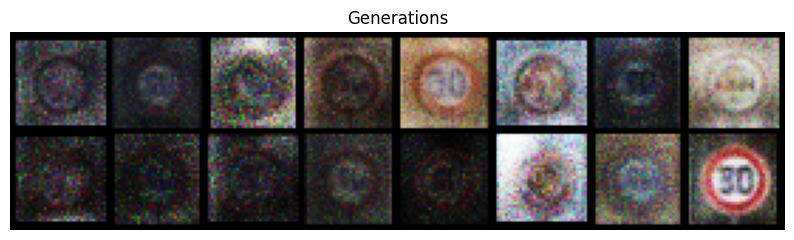

Epoch: 81, discrimiantor fake error: 0.28, discriminator real acc: 0.721
Epoch: 82, discrimiantor fake error: 0.274, discriminator real acc: 0.727
Epoch: 83, discrimiantor fake error: 0.276, discriminator real acc: 0.723
Epoch: 84, discrimiantor fake error: 0.278, discriminator real acc: 0.723
Epoch: 85, discrimiantor fake error: 0.281, discriminator real acc: 0.72
Epoch: 86, discrimiantor fake error: 0.282, discriminator real acc: 0.717
Epoch: 87, discrimiantor fake error: 0.29, discriminator real acc: 0.71
Epoch: 88, discrimiantor fake error: 0.285, discriminator real acc: 0.717
Epoch: 89, discrimiantor fake error: 0.283, discriminator real acc: 0.72
Epoch: 90, discrimiantor fake error: 0.287, discriminator real acc: 0.712


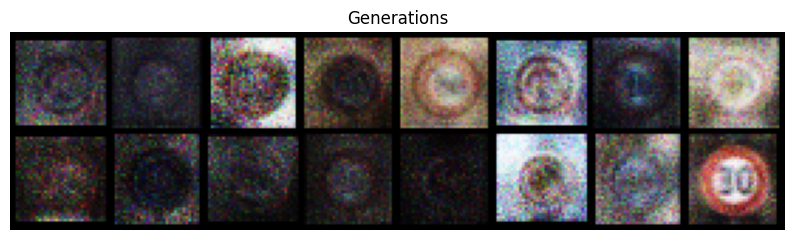

Epoch: 91, discrimiantor fake error: 0.284, discriminator real acc: 0.714
Epoch: 92, discrimiantor fake error: 0.277, discriminator real acc: 0.719
Epoch: 93, discrimiantor fake error: 0.285, discriminator real acc: 0.716
Epoch: 94, discrimiantor fake error: 0.284, discriminator real acc: 0.716
Epoch: 95, discrimiantor fake error: 0.284, discriminator real acc: 0.717
Epoch: 96, discrimiantor fake error: 0.296, discriminator real acc: 0.703
Epoch: 97, discrimiantor fake error: 0.285, discriminator real acc: 0.716
Epoch: 98, discrimiantor fake error: 0.283, discriminator real acc: 0.717
Epoch: 99, discrimiantor fake error: 0.279, discriminator real acc: 0.719


In [21]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        discriminator_optimizer.zero_grad()

        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) 

        output = discriminator(real_images).view(-1)

        error_discriminator_real = criterion(output, label)

        discriminator_real_acc.append(output.mean().item())


        noise = torch.randn(b_size, latent_dim,device=device)

        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)

        output = discriminator(fake_images.detach()).view(-1)

        error_discriminator_fake = criterion(output, label_fake)

        discriminator_fake_acc.append(output.mean().item())

        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()

        discriminator_optimizer.step()


        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)

        output = discriminator(fake_images).view(-1)

        error_generator = criterion(output, label)

        error_generator.backward()
        D_G_z2 = output.mean().item()

        generator_optimizer.step()


        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

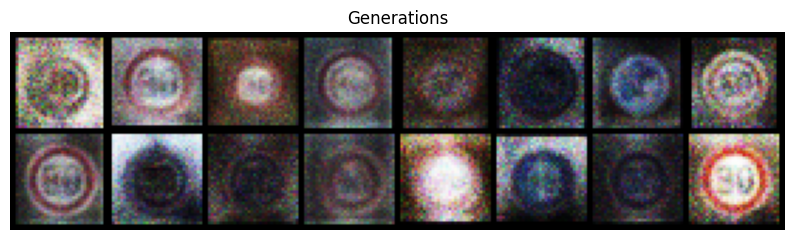

In [51]:
fixed_noise = torch.randn(16, latent_dim,device=device)
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()